# Open Images v6

[Open Images](https://storage.googleapis.com/openimages/web/download.html)是一个大型图像的数据集。这些数据有着图像级别的标注以及数千个类别的边界框。第六版数据集的物体检测子集包含600类物体的190万张图像。

这份Notebook演示了如何从该数据集中提取人脸的边界框。

# 准备工作
首先载入一些数据分析必要的模块。

In [1]:
# Open Images处理图像外的数据存储为csv格式，pandas是处理csv文件的不二之选。
import pandas as pd

# 处理的过程中涉及到一些数学运算。
import numpy as np

# Matplotlib用来绘制图像与边界框。
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# os包用来在不同系统下读取文件。
import os

对于下载好的所有文件，我们采用如下文件存储约定：
```
-open_images_v4        数据集根目录
|-annotation           所有csv文件
|-train                训练用图像文件夹
|-validation           验证用图像文件夹
|-open_images.ipynb    本notebook
```

设定数据集根目录：

In [2]:
root_dir = "/home/robin/hdd/data/raw/open_images/v6"

随机载入一张图片来测试数据集位置是否正确。

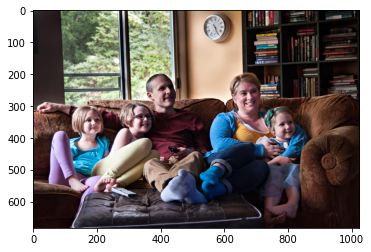

In [3]:
val_img = plt.imread(os.path.join(root_dir,'train','7f111c25a72d31d6.jpg'))
plt.imshow(val_img)

如果一切顺利，一张五口之家的图像应当显示在上方。

# 数据分析
并非所有的Open Images数据都有边界框。物体检测这部分数据被单独分了出来，称为Subset with Bounding Boxes (600 classes)。这个数据子集的标注与metadata包括：

- Boxes
- Segmentations
- Relationships
- Localized narratives
- Image labels
- Image IDs
- Metadata

其中Boxes包含我们感兴趣的边界框。

## Boxes

Boxes顾名思义存储了边界框。载入训练boxes对应文件并查看其内容。

In [4]:
boxes = pd.read_csv(os.path.join(root_dir, 'annotation/oidv6-train-annotations-bbox.csv'))
print("Total records: {}".format(boxes['Source'].count()))

Total records: 14610229


提取前5项看看。

In [5]:
boxes.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


其中XMin, XMax, YMin, YMax是归一化的边界框坐标。同时有两个重要的参数后边会用到：

- IsGroupOf: 如果边界框内同时包含了多个同类物体，则该项为1。
- IsDepiction: 如果人脸为卡通人物或者绘画作品，该项为1。

数据格式的完整描述可以在[官网](https://storage.googleapis.com/openimages/web/download.html)查到。

## Metadata

载入Metadata并查看其内容。

In [6]:
metadata = pd.read_csv(os.path.join(root_dir, 'annotation/class-descriptions-boxable.csv'), header=None)
metadata.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


这个文件非常简单，是类别编码与类别名的映射。以上几个文件所包含的信息足够我们开始提取人脸的工作了。

# 提取人脸
首先，我们需要找到"Human face"所对应的类别代码。

In [7]:
face_label = metadata[metadata[1] == "Human face"].iat[0, 0]
print("对应人脸Human face的类别代码是：{}".format(face_label))

对应人脸Human face的类别代码是：/m/0dzct


然后我们找到属于该类别的所有图像。同时对图像进行初步的筛选：

- 每个边界框内只包含一个人脸。
- 必须是真人的人脸。（可选）

In [8]:
is_face = boxes['LabelName'] == face_label
is_individual = boxes['IsGroupOf'] == 0
is_not_depiction = boxes['IsDepiction'] == 0
face_anns = boxes[is_face & is_individual]
print("筛选后获得数据总数：{}".format(face_anns['ImageID'].count()))
face_anns.head()

筛选后获得数据总数：1027451


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
53,000004f4400f6ec5,xclick,/m/0dzct,1,0.430000,0.496875,0.309991,0.565826,1,0,...,0,0,0.476250,0.430000,0.473750,0.496875,0.309991,0.476190,0.565826,0.461251
54,000004f4400f6ec5,xclick,/m/0dzct,1,0.568750,0.683125,0.218487,0.463119,0,0,...,0,0,0.629375,0.568750,0.624375,0.683125,0.218487,0.363212,0.463119,0.295051
130,0000271195f2c007,xclick,/m/0dzct,1,0.359375,0.646875,0.372917,0.916667,0,0,...,0,0,0.557813,0.359375,0.646875,0.509375,0.372917,0.597917,0.558333,0.916667
289,0000418f7ade0445,xclick,/m/0dzct,1,0.356667,0.400000,0.310000,0.386667,0,0,...,0,0,0.390000,0.393333,0.356667,0.400000,0.310000,0.386667,0.346667,0.346667
773,00006c07d2b033d1,xclick,/m/0dzct,1,0.325000,0.464063,0.229687,0.421875,0,0,...,0,0,0.415625,0.464063,0.325000,0.385937,0.229687,0.337500,0.325000,0.421875


接下来随机选择一幅图像，并将标注绘制在图像上。

Image id: 90bb5d57dadf570d


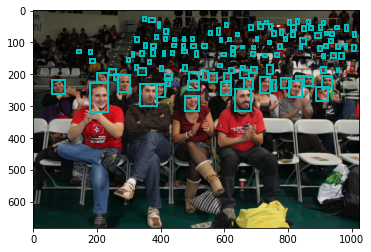

In [16]:
img_id = np.random.choice(face_anns['ImageID'])
print("Image id: {}".format(img_id))
img = plt.imread(os.path.join(root_dir, 'train', img_id+'.jpg'))

# Be careful sometimes the image is of gray format that there is only one channel. As the neural networks most likely require a fixed input channel, it would be better to convert the image into 3 channel.
img_height, img_width = img.shape[:2]

# Try to draw the annotation.
chosen_anns = face_anns[face_anns['ImageID'] == img_id]
bboxes = chosen_anns.loc[:, ['XMin', 'XMax', 'YMin', 'YMax']].values
currentAxis = plt.gca()
for each_box in bboxes:
    rect = Rectangle((each_box[0]*img_width, each_box[2]*img_height), 
                     (each_box[1] - each_box[0])*img_width, 
                     (each_box[3] - each_box[2])*img_height,
                     linewidth = 2,
                     edgecolor = 'c',
                     facecolor='None'
                    )
    currentAxis.add_patch(rect)
plt.imshow(img)